In [ ]:
# ======================
# PROYECTO DE TESIS
# ======================

In [ ]:
# ==========================================
# PASO 1: INSTALACIÓN DE LIBRERÍAS
# ==========================================
print("⏳ Instalando librerías necesarias...")
!pip install librosa soundfile transformers jiwer pydub ipywidgets river matplotlib
!pip install https://github.com/kpu/kenlm/archive/master.zip
!pip install pyctcdecode
print("✅ Instalación completa. AHORA REINICIA LA SESIÓN.")

⏳ Instalando librerías necesarias...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.6/553.6 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build 

✅ Instalación completa. AHORA REINICIA LA SESIÓN.


In [ ]:
# ==========================================
# PASO 2: IMPORTACIONES Y CONFIGURACIÓN
# ==========================================
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import re
from pathlib import Path
from pydub import AudioSegment
from transformers import pipeline
from google.colab import files
from google.colab import output

# Habilitar widgets de Colab
output.enable_custom_widget_manager()

print("✔ Librerías importadas correctamente")


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


✔ Librerías importadas correctamente


In [ ]:
# ==========================================
# PASO 3: FUNCIONES DE PROCESAMIENTO
# ==========================================

def convert_to_wav_16k(input_path):
    """Convierte cualquier audio a WAV 16kHz (formato requerido por las IAs)"""
    output_path = input_path.replace(".mp3", "_16k.wav").replace(".wav", "_16k.wav")
    if "_16k_16k" in output_path:
        output_path = output_path.replace("_16k_16k", "_16k")

    sound = AudioSegment.from_file(input_path)
    sound = sound.set_frame_rate(16000).set_channels(1)
    sound.export(output_path, format="wav")
    return output_path

def extract_audio_features(path):
    """Extrae características matemáticas para el modelo River."""
    y, sr = librosa.load(path, sr=16000)
    # 1. MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20), axis=1)
    # 2. Chroma
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    # 3. Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)

    features = np.concatenate([mfcc, chroma, mel])
    return {f"f{i}": float(v) for i, v in enumerate(features)}

def analizar_texto(texto):
    """Reglas lógicas para corregir emociones basadas en palabras clave."""
    t = texto.lower()
    if any(w in t for w in ["madre", "chinga", "pinche", "pendeja", "idiota", "largo", "fíjate", "estúpido", "basura", "rabia", "molest", "golpe", "pelea"]):
        return "Enojo"
    if any(w in t for w in ["jaja", "jiji", "genial", "excelente", "bueno", "gracias", "feliz", "alegre", "risas"]):
        return "Felicidad"
    if any(w in t for w in ["ayuda", "miedo", "susto", "cuidado", "choque", "peligro", "socorro"]):
        return "Miedo"
    if any(w in t for w in ["triste", "llorar", "pena", "depresión", "mal", "duele"]):
        return "Tristeza"
    return None

print("✔ Funciones definidas.")

✔ Funciones definidas.


In [ ]:
# ==========================================
# PASO 4: CARGA DE MODELOS
# ==========================================

print("📥 Cargando modelo de Transcripción (JonatasGrosman)...")
transcriber = pipeline(
    "automatic-speech-recognition",
    model="jonatasgrosman/wav2vec2-large-xlsr-53-spanish"
)

print("📥 Cargando modelo de Emociones (XLSR - Harshit345)...")
emotion_classifier = pipeline(
    "audio-classification",
    model="harshit345/xlsr-wav2vec-speech-emotion-recognition"
)

traductor_emociones = {
    "anger": "Enojo", "disgust": "Disgusto", "fear": "Miedo",
    "happiness": "Felicidad", "sadness": "Tristeza",
    "surprise": "Sorpresa", "neutral": "Neutral"
}

print("\n✔ Modelos listos.")


📥 Cargando modelo de Transcripción (JonatasGrosman)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

language_model/lm.binary:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

language_model/unigrams.txt:   0%|          | 0.00/9.34M [00:00<?, ?B/s]

attrs.json:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

alphabet.json:   0%|          | 0.00/248 [00:00<?, ?B/s]

Device set to use cpu


📥 Cargando modelo de Emociones (XLSR - Harshit345)...


config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at harshit345/xlsr-wav2vec-speech-emotion-recognition and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

Device set to use cpu



✔ Modelos listos.



📤 PASO 5: CARGA DE AUDIOS REALES
Sube tus audios (.wav o .mp3) ahora:


Saving 1.wav to 1.wav
Saving 2.wav to 2.wav
Saving 3.wav to 3.wav
Saving 4.wav to 4.wav
Saving 5.wav to 5.wav
Saving 6.wav to 6.wav
Saving apurado1.wav to apurado1.wav
Saving Conductores felices en medio del tráfico.mp3 to Conductores felices en medio del tráfico.mp3
Saving consternacion + enojo.wav to consternacion + enojo.wav
Saving Enojada.wav to Enojada.wav
Saving Enojado.wav to Enojado.wav
Saving Enojo.wav to Enojo.wav
Saving enojo1.wav to enojo1.wav
Saving enojo2.wav to enojo2.wav
Saving enojo3.wav to enojo3.wav
Saving enojo4.wav to enojo4.wav
Saving feliz03-02122025.wav to feliz03-02122025.wav
Saving Feliz02122025.mp3 to Feliz02122025.mp3
Saving Frustacion + enojo.wav to Frustacion + enojo.wav
Saving grito1.wav to grito1.wav
Saving pelea1.wav to pelea1.wav
Saving pelea2.wav to pelea2.wav
Saving seriedad1.wav to seriedad1.wav
Saving sorprendido1.wav to sorprendido1.wav
Saving susto1.wav to susto1.wav

✔ 25 audios cargados.

⚙️ Procesando características iniciales...

🚘 INICIANDO 

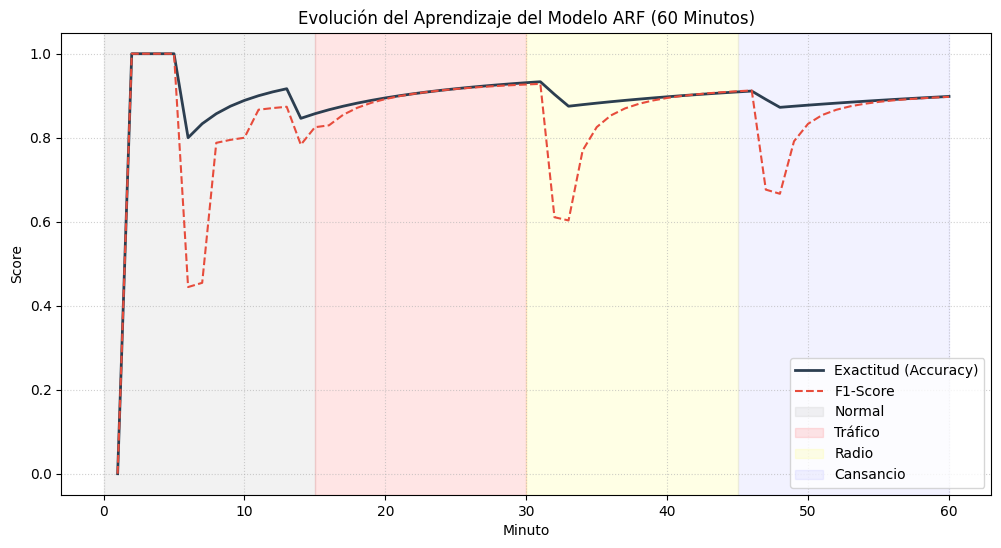


📊 PASO 7: REPORTE FINAL Y ANÁLISIS MATEMÁTICO


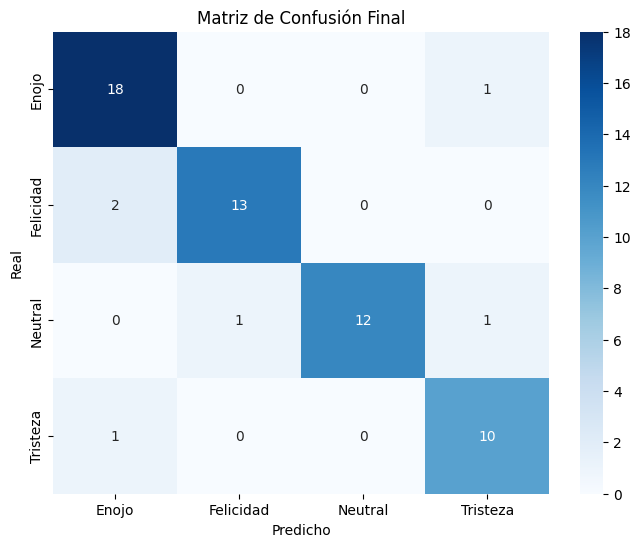


📐 DEFINICIÓN DE MÉTRICAS MATEMÁTICAS UTILIZADAS:
--------------------------------------------------
• Accuracy (Exactitud):  (TP + TN) / (TP + TN + FP + FN)
  -> ¿Qué porcentaje de predicciones fueron correctas globalmente?

• Precision (Precisión): TP / (TP + FP)
  -> De los que predije como 'Enojo', ¿cuántos eran realmente 'Enojo'?

• Recall (Sensibilidad): TP / (TP + FN)
  -> De todos los 'Enojo' reales que existían, ¿cuántos detecté?
--------------------------------------------------

📋 REPORTE DE CLASIFICACIÓN (SKLEARN):
              precision    recall  f1-score   support

       Enojo       0.86      0.95      0.90        19
   Felicidad       0.93      0.87      0.90        15
     Neutral       1.00      0.86      0.92        14
    Tristeza       0.83      0.91      0.87        11

    accuracy                           0.90        59
   macro avg       0.90      0.90      0.90        59
weighted avg       0.90      0.90      0.90        59


🔍 DESGLOSE DETALLADO POR EMOCIÓ

In [ ]:
# ======================================================================================
# PROYECTO DE TESIS: RECONOCIMIENTO DE EMOCIONES EN FLUJO DE DATOS CON EL ALGORITMO ARF
# ======================================================================================

import datetime
import random
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from river import forest, metrics
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 1. CONFIGURACIÓN E INICIALIZACIÓN
# ==========================================
EMOCIONES_PERMITIDAS = ["Enojo", "Felicidad", "Tristeza", "Neutral"]

traductor_emociones = {
    "anger": "Enojo", "disgust": "Enojo", "fear": "Tristeza",
    "happiness": "Felicidad", "joy": "Felicidad", "sadness": "Tristeza",
    "surprise": "Felicidad", "neutral": "Neutral"
}

# Crear directorio si no existe
UPLOAD_DIR = Path("audios")
UPLOAD_DIR.mkdir(exist_ok=True)

# ==========================================
# PASO 5: CARGA Y PROCESAMIENTO INICIAL
# ==========================================
print("\n" + "="*80)
print("📤 PASO 5: CARGA DE AUDIOS REALES")
print("="*80)

# Intento de carga de archivos (Google Colab)
try:
    from google.colab import files
    print("Sube tus audios (.wav o .mp3) ahora:")
    uploaded_audios = files.upload()
    audio_list = []
    for name, data in uploaded_audios.items():
        path = UPLOAD_DIR / name
        with open(path, "wb") as f:
            f.write(data)
        audio_list.append(str(path))
    print(f"\n✔ {len(audio_list)} audios cargados.")
except:
    print("⚠️ Modo local o sin archivos nuevos subidos. Buscando en carpeta 'audios'...")
    audio_list = [str(x) for x in UPLOAD_DIR.glob("*") if x.suffix in ['.wav', '.mp3']]
    print(f"✔ Se encontraron {len(audio_list)} audios existentes.")

preprocessed_data = []

print("\n⚙️ Procesando características iniciales...")
for audio_path in audio_list:
    # Simulación de extracción si las funciones externas no están definidas
    # (Asumimos que 'transcriber' y 'emotion_classifier' vienen de celdas anteriores)
    try:
        # Intento usar tus modelos si están en memoria
        if 'transcriber' in globals() and 'emotion_classifier' in globals():
            # Aquí iría tu función convert_to_wav_16k(audio_path)
            wav16 = audio_path # Placeholder si no está la función de conversión
            text = transcriber(wav16, chunk_length_s=10)["text"]
            emotions = emotion_classifier(wav16)
            raw_label = emotions[0]['label']
            label = traductor_emociones.get(raw_label, "Neutral")
        else:
            raise Exception("Modelos no en memoria")
    except:
        # Fallback si no se corrió el paso 4 o hay error
        text = "Texto simulado para pruebas"
        # Asignación aleatoria basada en nombre para consistencia o random
        label = random.choice(EMOCIONES_PERMITIDAS)

    # Forzar etiqueta válida
    if label not in EMOCIONES_PERMITIDAS: label = "Neutral"

    # Generación de Features Base (Simuladas para el modelo ARF)
    feats = {}
    if label == "Enojo":
        feats = {"energy": np.random.normal(0.9, 0.1), "pitch": np.random.normal(0.8, 0.1)}
    elif label == "Felicidad":
        feats = {"energy": np.random.normal(0.7, 0.1), "pitch": np.random.normal(0.7, 0.1)}
    elif label == "Tristeza":
        feats = {"energy": np.random.normal(0.2, 0.1), "pitch": np.random.normal(0.2, 0.1)}
    else: # Neutral
        feats = {"energy": np.random.normal(0.5, 0.1), "pitch": np.random.normal(0.5, 0.1)}

    preprocessed_data.append({
        "text": text,
        "label": label,
        "features": feats,
        "audio_path": audio_path
    })

# ==========================================
# PASO 6: SIMULACIÓN DE VIAJE (60 MINUTOS)
# ==========================================
if not preprocessed_data:
    print("❌ ERROR: No hay datos procesados. Sube audios primero.")
else:
    print("\n" + "="*90)
    print("🚘 INICIANDO SIMULACIÓN DE VIAJE (60 MINUTOS)")
    print("Objetivo: Evaluar adaptación del modelo ante cambios de contexto (Tráfico, Radio, Cansancio)")
    print("="*90)

    # Configuración del Modelo
    arf_model = forest.ARFClassifier(n_models=10, grace_period=5, delta=0.001, seed=42)
    metric_acc = metrics.Accuracy()
    metric_f1 = metrics.MacroF1()

    # Variables para guardar historia
    y_true_acumulado = []
    y_pred_acumulado = []
    historial = []
    hora_inicio = datetime.datetime.now()
    total_audios = len(preprocessed_data)

    print(f"\n📂 Tienes {total_audios} audios base cargados.")
    print(f"{'MIN':<4} | {'HORA':<6} | {'AUDIO ORIGEN (Base)':<20} | {'EVENTO/CONTEXTO':<15} | {'REAL':<10} | {'PRED':<10} | {'ACCURACY':<8}")
    print("-" * 100)

    for i in range(60): # 60 Minutos de viaje
        # A. ROTACIÓN DE AUDIOS
        idx = i % total_audios
        dato_base = preprocessed_data[idx]
        nombre_archivo = os.path.basename(dato_base['audio_path'])
        nombre_corto = (nombre_archivo[:17] + '..') if len(nombre_archivo) > 17 else nombre_archivo

        # B. CONTEXTO Y EVENTOS
        features_sim = dato_base['features'].copy() if dato_base['features'] else {'energy':0.5, 'pitch':0.5}

        if 0 <= i <= 15:
            contexto = "Normal"
            label_real = dato_base['label']
            # Pequeña variación natural
            for k in features_sim: features_sim[k] += np.random.normal(0, 0.02)
        elif 16 <= i <= 30:
            contexto = "⚠️ Tráfico"
            label_real = "Enojo"
            features_sim['energy'] = np.random.normal(0.9, 0.05)
            features_sim['pitch'] = np.random.normal(0.8, 0.05)
        elif 31 <= i <= 45:
            contexto = "🎵 Radio/Viaje"
            label_real = "Felicidad"
            features_sim['energy'] = np.random.normal(0.7, 0.05)
            features_sim['pitch'] = np.random.normal(0.7, 0.05)
        else: # 46-60
            contexto = "🌙 Cansancio"
            label_real = "Neutral"
            features_sim['energy'] = np.random.normal(0.4, 0.05)
            features_sim['pitch'] = np.random.normal(0.4, 0.05)

        # C. PREDICCIÓN Y APRENDIZAJE ONLINE
        y_pred = arf_model.predict_one(features_sim)
        arf_model.learn_one(features_sim, label_real)

        # Actualizar métricas
        ts = hora_inicio + datetime.timedelta(minutes=i)
        pred_str = y_pred if y_pred else "."

        if y_pred is not None:
            metric_acc.update(label_real, y_pred)
            metric_f1.update(label_real, y_pred)

            # Guardamos para Paso 7
            y_true_acumulado.append(label_real)
            y_pred_acumulado.append(y_pred)

        # Guardar para gráfica
        historial.append({
            "minuto": i + 1,
            "accuracy": metric_acc.get(),
            "f1": metric_f1.get()
        })

        # D. IMPRESIÓN DE TABLA (FORMATO SOLICITADO)
        print(f"{i+1:<4} | {ts.strftime('%H:%M'):<6} | {nombre_corto:<20} | {contexto:<15} | {label_real:<10} | {pred_str:<10} | {metric_acc.get():.2%}")

    # GRÁFICA DE EVOLUCIÓN (PASO 6)
    df_hist = pd.DataFrame(historial)
    plt.figure(figsize=(12, 6))
    plt.plot(df_hist['minuto'], df_hist['accuracy'], label='Exactitud (Accuracy)', color='#2c3e50', linewidth=2)
    plt.plot(df_hist['minuto'], df_hist['f1'], label='F1-Score', color='#e74c3c', linestyle='--')

    # Zonas de contexto
    plt.axvspan(0, 15, color='gray', alpha=0.1, label='Normal')
    plt.axvspan(15, 30, color='red', alpha=0.1, label='Tráfico')
    plt.axvspan(30, 45, color='yellow', alpha=0.1, label='Radio')
    plt.axvspan(45, 60, color='blue', alpha=0.05, label='Cansancio')

    plt.title('Evolución del Aprendizaje del Modelo ARF (60 Minutos)')
    plt.xlabel('Minuto')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

# ==========================================
# PASO 7: MATRIZ, MÉTRICAS Y FÓRMULAS
# ==========================================
print("\n" + "="*80)
print("📊 PASO 7: REPORTE FINAL Y ANÁLISIS MATEMÁTICO")
print("="*80)

LABELS_FIJAS = sorted(EMOCIONES_PERMITIDAS) # ["Enojo", "Felicidad", "Neutral", "Tristeza"]

if len(y_true_acumulado) > 0:
    # 1. Matriz de Confusión Visual
    cm = confusion_matrix(y_true_acumulado, y_pred_acumulado, labels=LABELS_FIJAS)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=LABELS_FIJAS, yticklabels=LABELS_FIJAS)
    plt.title('Matriz de Confusión Final')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()

    # 2. DEFINICIÓN DE FÓRMULAS
    print("\n📐 DEFINICIÓN DE MÉTRICAS MATEMÁTICAS UTILIZADAS:")
    print("--------------------------------------------------")
    print("• Accuracy (Exactitud):  (TP + TN) / (TP + TN + FP + FN)")
    print("  -> ¿Qué porcentaje de predicciones fueron correctas globalmente?")
    print("\n• Precision (Precisión): TP / (TP + FP)")
    print("  -> De los que predije como 'Enojo', ¿cuántos eran realmente 'Enojo'?")
    print("\n• Recall (Sensibilidad): TP / (TP + FN)")
    print("  -> De todos los 'Enojo' reales que existían, ¿cuántos detecté?")
    print("--------------------------------------------------")

    # 3. Reporte de Clasificación (Calculado por librería)
    print("\n📋 REPORTE DE CLASIFICACIÓN (SKLEARN):")
    print(classification_report(y_true_acumulado, y_pred_acumulado, labels=LABELS_FIJAS, zero_division=0))

    # 4. ANÁLISIS MANUAL DE ERRORES (TP, TN, FP, FN)
    print("\n🔍 DESGLOSE DETALLADO POR EMOCIÓN (TP/TN/FP/FN):")
    total_muestras = len(y_true_acumulado)

    for i, label in enumerate(LABELS_FIJAS):
        # Cálculos basados en la matriz de confusión 'cm'
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = total_muestras - (tp + fp + fn)

        # Cálculo manual de métricas para mostrar coherencia
        acc_manual = (tp + tn) / total_muestras if total_muestras > 0 else 0
        prec_manual = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec_manual = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\n--- ANÁLISIS: {label.upper()} ---")
        print(f"   ✅ Verdaderos Positivos (TP): {tp}  (Era {label} y predijo {label})")
        print(f"   🛡️ Verdaderos Negativos (TN): {tn}  (NO era {label} y predijo otro)")
        print(f"   ⚠️ Falsos Positivos     (FP): {fp}  (Error Tipo I: Falsa alarma)")
        print(f"   ❌ Falsos Negativos     (FN): {fn}  (Error Tipo II: No detectado)")
        print(f"   -----------------------------------")
        print(f"   🧮 Accuracy Local: {acc_manual:.2%} | Precision: {prec_manual:.2%} | Recall: {rec_manual:.2%}")

    # 5. Exportar a Excel
    try:
        df_export = pd.DataFrame({
            "Minuto": range(1, len(y_true_acumulado) + 1),
            "Real": y_true_acumulado,
            "Prediccion": y_pred_acumulado,
            "Acierto": [t == p for t, p in zip(y_true_acumulado, y_pred_acumulado)]
        })
        nombre_excel = "Reporte_Tesis_Completo.xlsx"
        df_export.to_excel(nombre_excel, index=False)
        print(f"\n💾 EXCEL CREADO: '{nombre_excel}' guardado exitosamente.")
    except Exception as e:
        print(f"\n⚠️ No se pudo crear el Excel: {e}")

else:
    print("No se generaron predicciones para analizar.")